<a href="https://colab.research.google.com/github/rheopy/rheofit/blob/master/data/Yielding%20and%20Flow%20of%20Monodisperse%20Emulsions/TC_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Figure 5 from article:



```
@article{mason1996yielding,
  title={Yielding and flow of monodisperse emulsions},
  author={Mason, TG and Bibette, J and Weitz, DA},
  journal={Journal of colloid and interface science},
  volume={179},
  number={2},
  pages={439--448},
  year={1996},
  publisher={Elsevier}
}
```

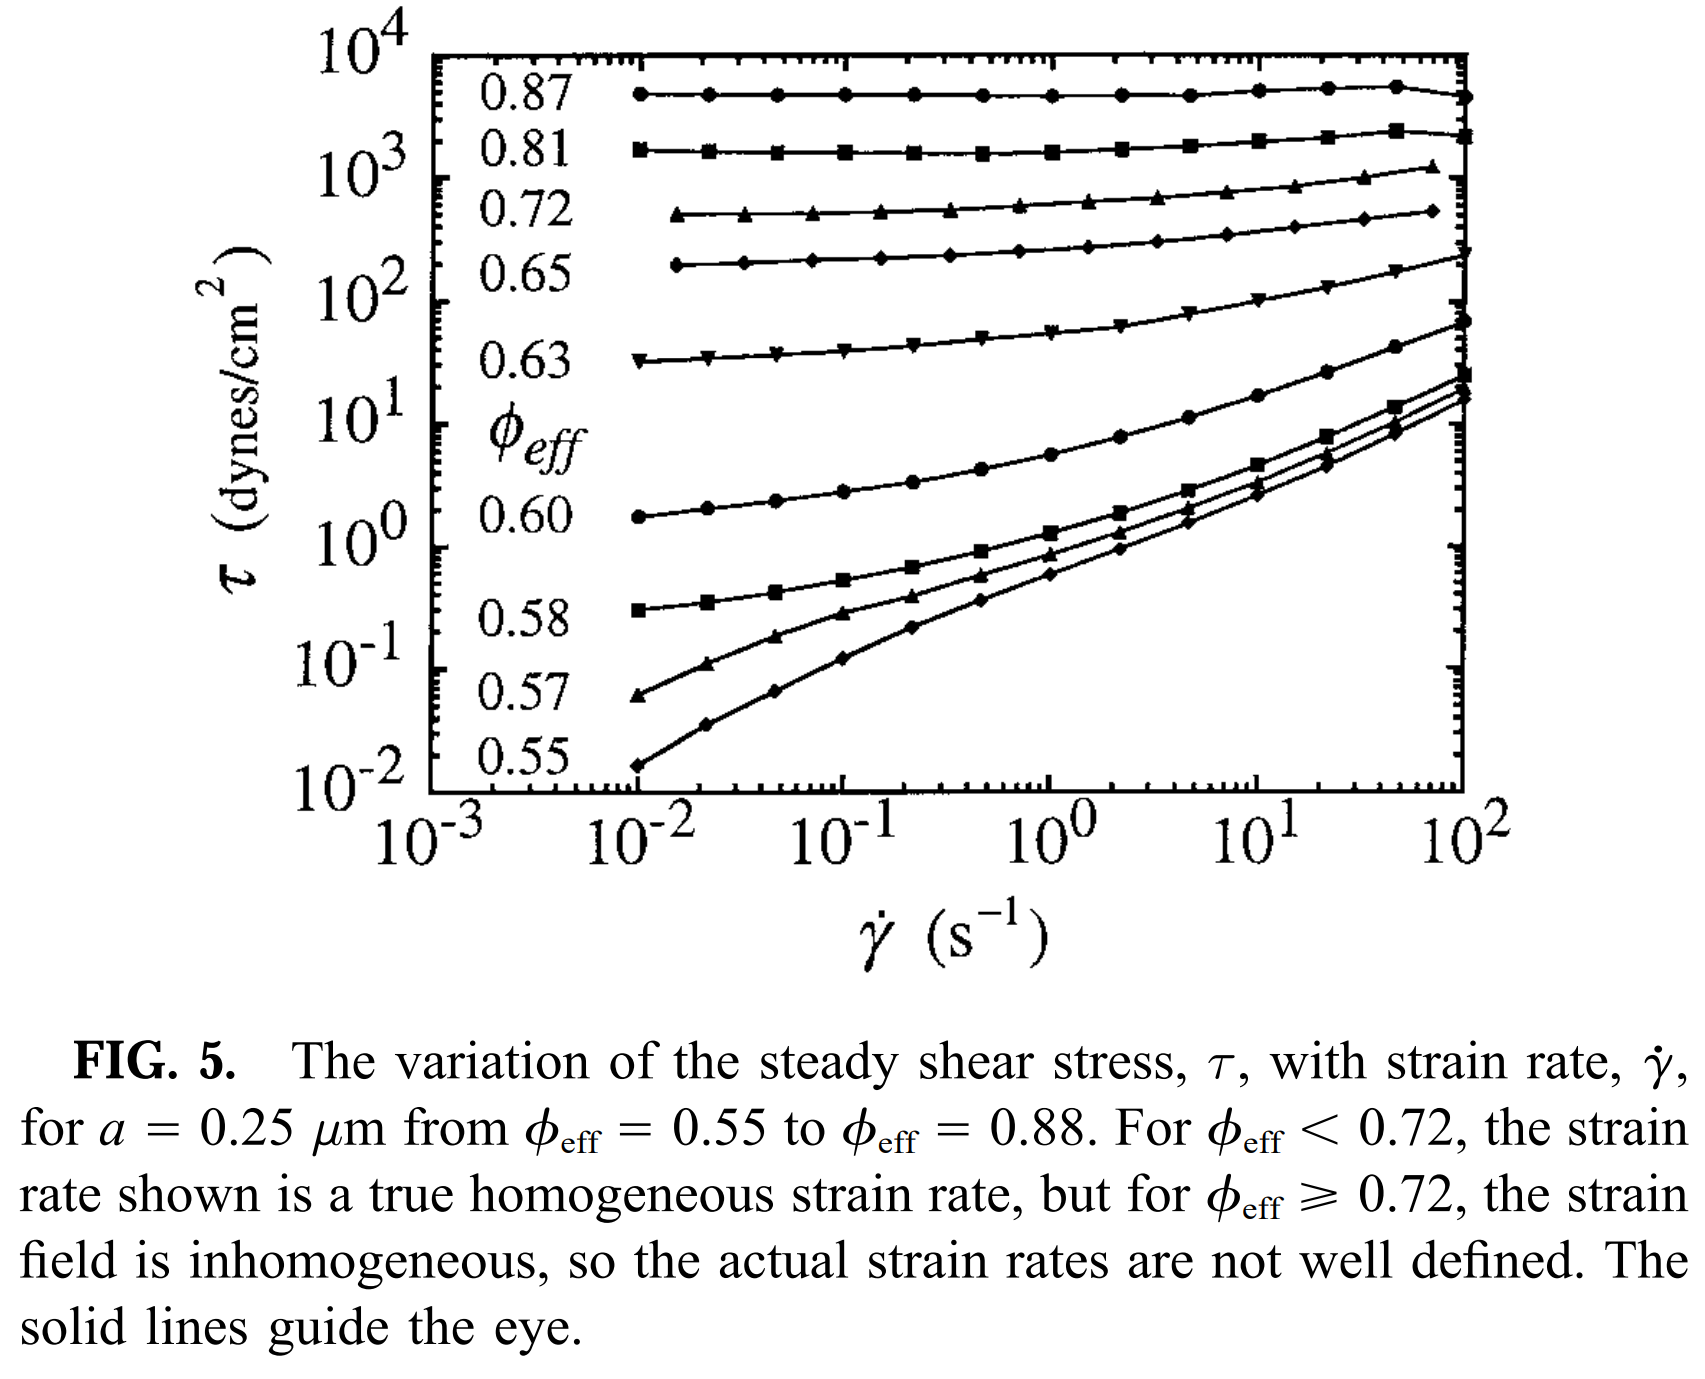

In [1]:
!pip install git+https://github.com/rheopy/rheofit.git

  Cloning https://github.com/rheopy/rheofit.git to /tmp/pip-req-build-6lf7qf5o
  Running command git clone -q https://github.com/rheopy/rheofit.git /tmp/pip-req-build-6lf7qf5o
  Created wheel for rheofit: filename=rheofit-0.1.0-cp36-none-any.whl size=9874 sha256=f7c262dbcfd24133784dfd7c81b2efcd3fdcd305af1f992981e24c8654eaa27f
  Stored in directory: /tmp/pip-ephem-wheel-cache-3gnfmcav/wheels/a4/58/61/22fb357c158d287fa7e6b6a2b1cc7379d68d1d40fdbb8daf64
Successfully built rheofit


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import lmfit
from IPython.display import Math

import rheofit
import pybroom as pb
import corner

import seaborn as sns
import io
from scipy.interpolate import UnivariateSpline
import numpy as np


In [3]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

In [4]:
!git clone https://github.com/rheopy/rheofit.git

fatal: destination path 'rheofit' already exists and is not an empty directory.


In [5]:
#check units - assuming SI

filename_fig2a='jcis.1996.0235_fig5.csv'
folder_name='Yielding and Flow of Monodisperse Emulsions'
xlabel='Shear rate'
ylabel='Stress'

sample_list=list(pd.read_csv(f'/content/rheofit/data/{folder_name}/{filename_fig2a}',nrows=1).columns)[::2]
data_table=pd.read_csv(f'/content/rheofit/data/{folder_name}/{filename_fig2a}',skiprows=1)
data_table

data_dict={}
for sample_index, sample_label in enumerate(sample_list):
  single_table=data_table.iloc[:,[sample_index*2,sample_index*2+1]]
  single_table.columns=[xlabel,ylabel]
  single_table.sort_values(by=xlabel,inplace=True)
  single_table[ylabel]=single_table[ylabel]/10

  data_dict[sample_label]=single_table

# data interpolation example
# data=pd.read_excel('FC_0775.xlsx')
# int_y=UnivariateSpline(data['Shear rate'],data['Stress'],k=1)
# int_x=np.logspace(np.log10(min(data['Shear rate'])),np.log10(max(data['Shear rate'])),100)
# int_data=pd.DataFrame()
# int_data['Shear rate']=int_x
# int_data['Stress']=int_y(int_x)
# data_dict['FC_0775.xlsx']=data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [6]:
TC=None
TC=rheofit.models.TC_model
TC.set_param_hint('TC_eta_bg',value=0.1,vary=True)

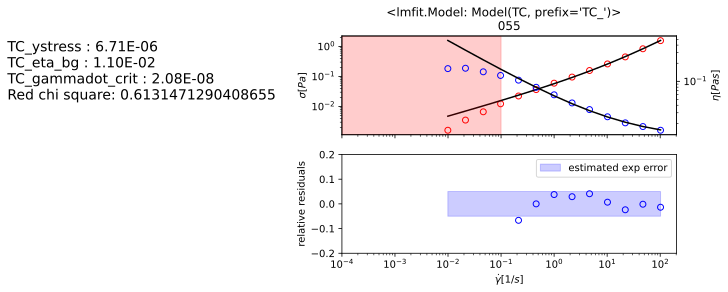

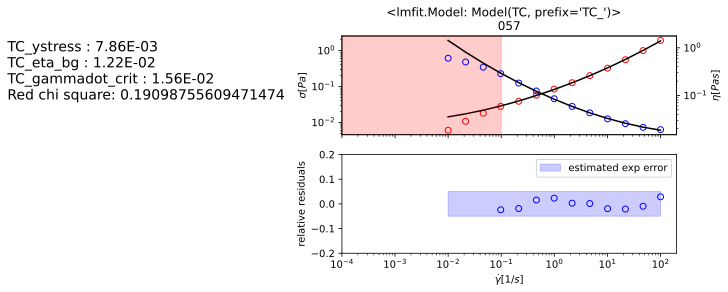

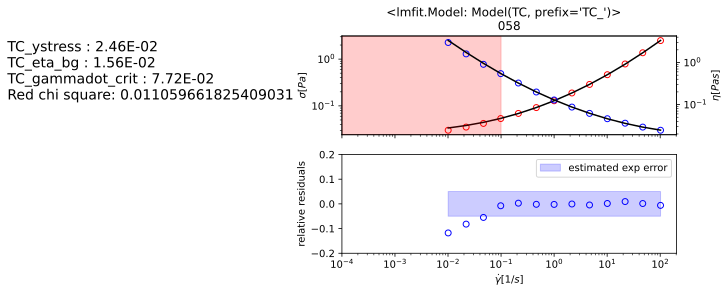

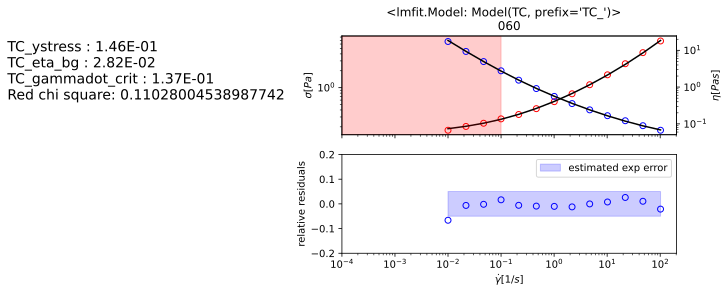

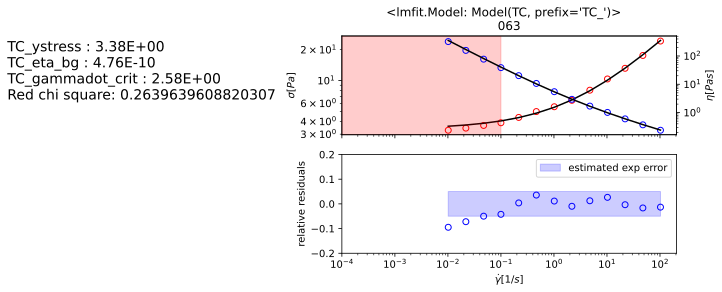

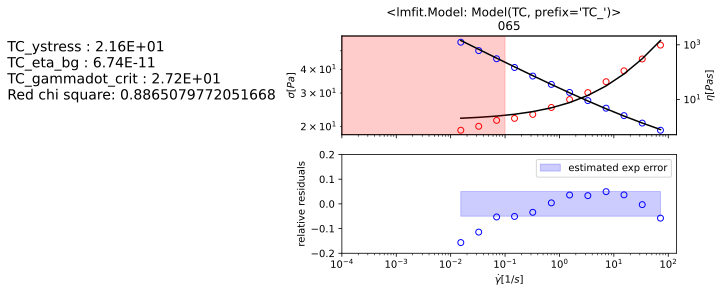

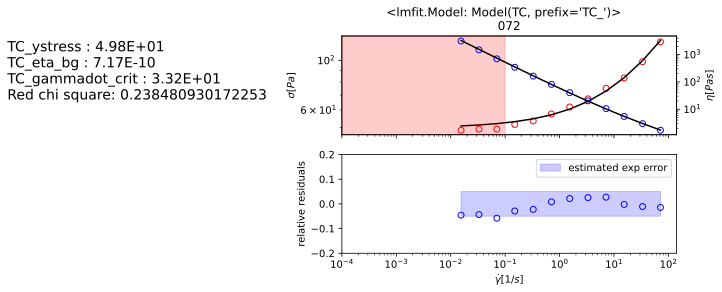

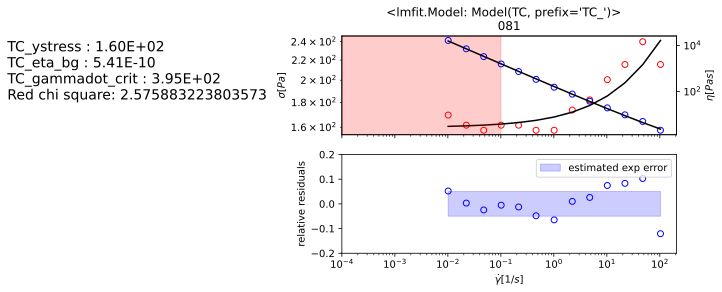

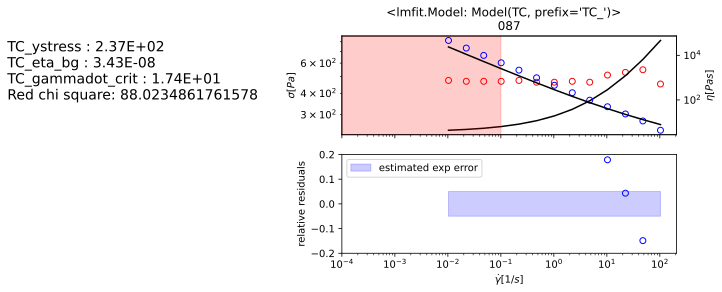

In [7]:
fit_res_dict={}

model = TC

min_shear_rate=0.1
max_shear_rate=10000

for filename, data in data_dict.items():
    mask=(data['Shear rate']>=min_shear_rate) & (data['Shear rate']<=max_shear_rate)    
    fit_res=model.fit(data['Stress'],x=data['Shear rate'],
                                     weights=1/(0.05*data[mask]['Stress']),
                                     nan_policy='omit')
    fit_res_dict[filename]=fit_res
    
for filename,fit_res in fit_res_dict.items():
    rheofit.visualization.plot_fit_res(fit_res, show_par_values=True);
    plt.title(filename)
    
    plt.axvspan(0.0001,min_shear_rate,color='red',alpha=0.2)
    plt.xlim(0.0001)  



In [8]:

table_result=pb.tidy(fit_res_dict)
table_result['vol_frac']=table_result['key'].map(lambda x: int(x[1:])/100)
table_result.pivot(index='vol_frac', columns='name', values='value')

name,TC_eta_bg,TC_gammadot_crit,TC_ystress
vol_frac,,,
0.55,1.095688e-02,2.082619e-08,0.000007
0.57,1.219644e-02,1.564198e-02,0.007861
0.58,1.562919e-02,7.720810e-02,0.024635
0.6,2.815950e-02,1.374345e-01,0.145586
0.63,4.757705e-10,2.584590e+00,3.377247
0.65,6.740675e-11,2.722559e+01,21.591802
0.72,7.171839e-10,3.324884e+01,49.846378
0.81,5.411027e-10,3.950968e+02,159.856377
0.87,3.429011e-08,1.743288e+01,237.370357


Text(0, 0.5, 'Stress')

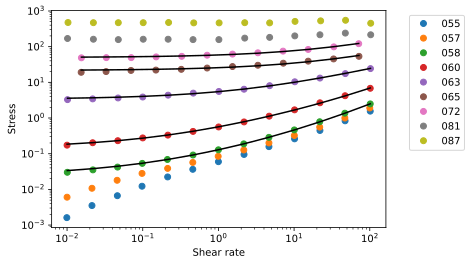

In [9]:
for label,fit_res in fit_res_dict.items():
  if label in ['055','081','087','057']:
    plt.plot(fit_res.userkws['x'],fit_res.data,'o', label=label)

  else:
    plt.plot(fit_res.userkws['x'],fit_res.data,'o', label=label)
    plt.plot(fit_res.userkws['x'],fit_res.eval(), color='black')
  
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best', bbox_to_anchor=(1.25, 1))
plt.xlabel(xlabel)
plt.ylabel(ylabel)

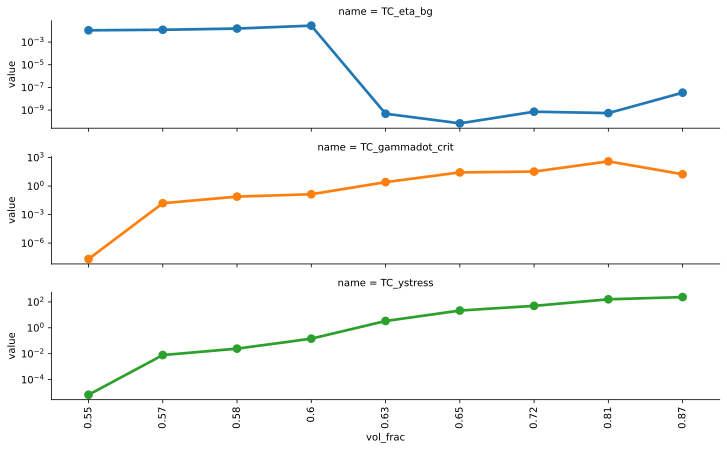

In [10]:
g = sns.catplot(x="vol_frac", y="value",
                hue="name", row="name",
                data=table_result, kind="point",
                dodge=False,
                sharey=False,
                height=2, aspect=5).set_xticklabels(rotation=90).set(yscale="log")


In [11]:
res_table=table_result.pivot(index='vol_frac', columns='name', values='value')

Text(0, 0.5, 'eta_bg')

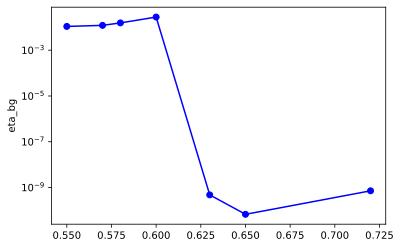

In [12]:
mask=[True,True,True,True,True,True,True,False,False]
plt.plot(res_table.index[mask],res_table['TC_eta_bg'][mask],'-o', color='blue')
plt.yscale('log')
plt.ylabel('eta_bg')

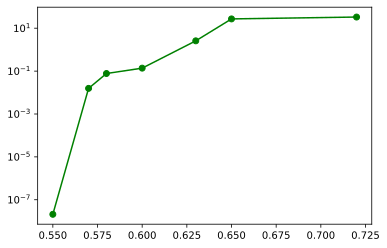

In [13]:
plt.plot(res_table.index[mask],res_table['TC_gammadot_crit'][mask],'-o', color='green')
plt.yscale('log')

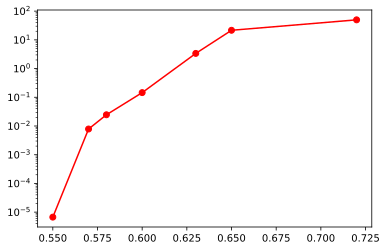

In [14]:
plt.plot(res_table.index[mask],res_table['TC_ystress'][mask],'-o', color='red')
plt.yscale('log')